## **Import Required Libraries**

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ee
import geemap
import geopandas as gpd
import rasterio as rio
from geemap import cartoee
import cartopy.crs as ccrs
import geedim

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams['font.serif'] = "Times New Roman"

## **Initialize a Map Object**

In [2]:
# ee.Authenticate()

In [3]:
# ee.Initialize(project="krishnagopal-iit-roorkee")

In [2]:
Map = geemap.Map(basemap="Esri.WorldImagery")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## **Import the Region of Interest**

In [3]:
# Read the Africa country shapefile
africa_gdf = gpd.read_file(r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\datasets\Africa_Country_Boundary\afr_g2014_2013_0.shp")

# Convert the shapefile into earth engine feature collection
africa_ee = ee.FeatureCollection("users/geonextgis/Africa_Country_Boundary")
roi_style = {
    "fillColor": "00000000",
    "color": "black",
    "width": 0.5
}
Map.addLayer(africa_ee.style(**roi_style), {}, "Africa Boundary")
Map.centerObject(africa_ee, 4)

## **Read all the Required Dataset**
1. Crop Calendar
2. FAO Yield
3. Crop Mask

In [4]:
# Read the crop calendar dataset
crop_calendar_df = pd.read_excel(r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\datasets\processed_datasets\crop_calendar_ssa.xlsx", sheet_name="maize_major")
print(crop_calendar_df.shape)
crop_calendar_df.head()

(59, 7)


,country,plant,plant_start,plant_end,harvest,harvest_start,harvest_end
0,Abyei,121.0,91,151,237.5,213,262
1,Algeria,88.0,56,120,285.0,233,337
2,Angola,281.5,244,319,90.0,60,120
3,Benin,90.0,60,120,243.0,213,273
4,Botswana,357.5,319,31,136.0,106,166


In [5]:
# Read the FAO data
fao_yield_df = pd.read_csv(r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\datasets\FAOSTAT_data_SSA_Maize_1961-2022.csv")

# Change the name of the few countries 
new_country_names = {
    "C?te d'Ivoire": "Côte d'Ivoire",
    "Cabo Verde": "Cape Verde"
}

fao_yield_df.replace(to_replace=new_country_names, inplace=True)
print(fao_yield_df.shape)
fao_yield_df.head()

(3043, 5)


,Area,Element,Item,Year,Yield(tons/ha)
0,Algeria,Yield,Maize (corn),1961,0.9746
1,Algeria,Yield,Maize (corn),1962,0.5400
2,Algeria,Yield,Maize (corn),1963,1.0716
3,Algeria,Yield,Maize (corn),1964,1.1703
4,Algeria,Yield,Maize (corn),1965,1.1000


Number of countries in the FAO data: 53


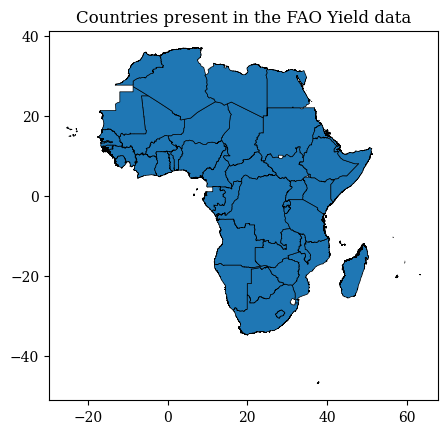

In [6]:
# Check the number of countries in the FAO data
print("Number of countries in the FAO data:", fao_yield_df["Area"].nunique())

# Store the name of the countries in a specific variable
fao_countries = fao_yield_df["Area"].unique()

# Plot the countries present in the FAO yield data
africa_gdf[africa_gdf["ADM0_NAME"].isin(fao_countries)].plot(edgecolor="black", linewidth=0.5)
plt.title("Countries present in the FAO Yield data");

In [7]:
# # Read the Maize Harvested Area dataset
# maize_harv_area = ee.Image("projects/krishnagopal-msc-dissertation/assets/maize_HarvestedAreaHectares")\
#                     .clip(africa_ee)

# harv_area_vis = {
#     "bands": ["b1"],
#     "min": 0,
#     "max": 2550,
#     "palette": ['#d73027','#fc8d59','#fee08b','#d9ef8b','#91cf60','#1a9850']
# }

# Map.addLayer(maize_harv_area, harv_area_vis, "Maize Harvested Area", False)

In [8]:
# # Plot the Maize harvested area
# fig = plt.figure(figsize=(7, 7))

# region = [-19.4, -37.0, 54.2, 39.3]

# ax = cartoee.get_map(maize_harv_area, 
#                      cmap="viridis", 
#                      vis_params={"min": 0, "max": 2550},
#                      region=region)

# cb = cartoee.add_colorbar(ax=ax, vis_params={"min": 0, "max": 2250}, loc="right", 
#                           cmap="viridis", label="Maize Harvested Area (hectares)")

# ax.set_title("Average number of hectares harvested per land-area\nof a gridcell during the 1997-2003")

# plt.show()

In [9]:
# # Prepare the Cropland mask from ESRI LULC dataset
# # Read the ESRI LULC 10M data and filter it with ROI
# esri_lulc_ts= ee.ImageCollection("projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m_TS")
# esri_cropland_mask = esri_lulc_ts.filterBounds(africa_ee.geometry().bounds())\
#                                  .mode()\
#                                  .eq(5)\
#                                  .selfMask()\
#                                  .clip(africa_ee.geometry().bounds())

# Read the extracted crop mask
esri_cropland_mask = ee.Image("projects/krishnagopal-iit-roorkee/assets/ssa-crop-yield-forecasting/ssa_cropland_mask")
esri_cropland_vis = {"min": 0, "max": 1, "palette": ["#FFDB5C"]}
Map.addLayer(esri_cropland_mask, esri_cropland_vis, "ESRI Cropland Mask")

In [10]:
# # Extract the crop mask
# cropmask_export_task = ee.batch.Export.image.toAsset(image=cropland_mask,
#                                                      assetId="projects/krishnagopal-iit-roorkee/assets/ssa-crop-yield-forecasting/ssa_cropland_mask",
#                                                      description="SSA_Cropland_Mask",
#                                                      region=africa_ee.geometry().bounds(),
#                                                      scale=10,
#                                                      maxPixels=1e13)

# cropmask_export_task.start()

## **Prepare Data for Each Country**

In [11]:
# Filter the yield dataframe from 2009-2022
fao_yield_df = fao_yield_df[(fao_yield_df["Year"]>=2008) & (fao_yield_df["Year"]<=2022)]
print(fao_yield_df.shape)
fao_yield_df.head()

(746, 5)


,Area,Element,Item,Year,Yield(tons/ha)
47,Algeria,Yield,Maize (corn),2008,4.4714
48,Algeria,Yield,Maize (corn),2009,3.0914
49,Algeria,Yield,Maize (corn),2010,2.5827
50,Algeria,Yield,Maize (corn),2011,2.3374
51,Algeria,Yield,Maize (corn),2012,2.5583


In [13]:
# Read the Terra Net Primary Production Global dataset
npp = ee.ImageCollection("FAO/WAPOR/2/L1_NPP_D")\
        .select("L1_NPP_D")\

# Write a function to map the time component in the NPP image collection
def assign_time_comp(image):

    time_index = ee.String(image.get("system:index")).slice(-4,)
    year = ee.Number(ee.String("20").cat(time_index.slice(0, 2)))
    dakad_id = ee.Number.parse(time_index.slice(2, ))

    end_day = ee.Number(dakad_id).multiply(ee.Number(10))
    start_day = ee.Number(end_day).subtract(ee.Number(10))

    # Define the start date and end date
    initial_date = ee.Date(year)
    start_day_date = initial_date.advance(start_day, "day")
    end_day_date = initial_date.advance(end_day, "day")

    return image.set({
        "start_date": start_day_date,
        "end_date": end_day_date,
        "system:time_start": start_day_date.millis(),
        "system:time_end": end_day_date.millis()
    })

# Apply the function over the image collection
npp_mapped = npp.map(assign_time_comp)

In [14]:
# Define the years to be taken
years = np.arange(2009, 2023)

#### Main Algorithm

In [15]:
# Select a country
country = "South Africa"
country_geom = africa_ee.filter(ee.Filter.eq("ADM0_NAME", country)).first()\
                        .geometry()

year = 2010
plant_start = crop_calendar_df[crop_calendar_df["country"]==country]["plant_start"].values[0]
harvest_end = crop_calendar_df[crop_calendar_df["country"]==country]["harvest_end"].values[0]

# Extract the duration
if plant_start > harvest_end:
    duration = (365 - plant_start) + harvest_end
else:
    duration = harvest_end - plant_start

# Define the start and end date
initial_date = ee.Date(str(year))
start_date = initial_date.advance(int(plant_start), "day")
end_date = start_date.advance(int(duration), "day")

In [16]:
# Filter out the NPP data for the growing days
npp_filtered = npp_mapped.filterDate(start_date, end_date)

# Calculate average NPP per pixel during the growing period
npp_average_per_pixel = npp_filtered.mean()\
                                    .toInt()\
                                    .rename("average_npp")\
                                    .clip(country_geom)\
                                    .updateMask(esri_cropland_mask)
                  
npp_vis_params = {
    "min": 665,
    "max": 4155,
    "palette": ['#ffffcc','#d9f0a3','#addd8e','#78c679','#31a354','#006837']
}
Map.addLayer(npp_average_per_pixel, npp_vis_params, "NPP Average per Pixel")

In [61]:
# Calculate the mean country NPP 
country_npp_mean = npp_average_per_pixel.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=country_geom.bounds(),
    scale=250, 
    maxPixels=1e16,
    bestEffort=True)

# Print the 
country_npp_mean = int(country_npp_mean.getInfo()["average_npp"])
print("Average Country NPP:", country_npp_mean)

Total Country NPP: 2046


In [62]:
# Calculate the Ratio per pixel
npp_ratio_per_pixel = npp_average_per_pixel.divide(country_npp_mean)\
                                           .toFloat()\
                                           .rename("ratio_npp")
npp_ratio_vis_params = {
    "min": 0,
    "max": 2,
    "palette": ['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026']
}
Map.addLayer(npp_ratio_per_pixel, npp_ratio_vis_params, "NPP Ratio per Pixel")

In [66]:
# Distribute the FAO yield over the pixel
fao_yield_value = fao_yield_df[(fao_yield_df["Area"]==country) & (fao_yield_df["Year"]==year)]["Yield(tons/ha)"].values[0]

npp_yield_per_pixel = npp_ratio_per_pixel.multiply(country_npp_mean)
npp_ratio_vis_params = {
    "min": 0,
    "max": 4.5,
    "palette": ['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026']
}
Map.addLayer(npp_ratio_per_pixel, npp_ratio_vis_params, "NPP Ratio per Pixel")

4.6736